In [1]:
import pandas as pd
import re
import numpy as np
import emoji
import contractions
import unidecode
from tqdm import tqdm

In [2]:
data = pd.read_csv('cleaned_data_for_classification.csv')

/var/folders/2k/fhkt65ls68nbd5xt0lj3sbww0000gn/T/ipykernel_6221/1478134738.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaned_data_for_classification.csv')


In [3]:
len(data)

368413

In [4]:
data['channel'].value_counts()

delivery    326248
curbside     42162
Name: channel, dtype: int64

In [5]:
data.columns

Index(['author id', 'created_at', 'geo', 'id', 'lang', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'source', 'tweet',
       'Category', 'channel', 'new_tweet', 'Year', 'Month', 'Day'],
      dtype='object')

In [6]:
data['Category'].value_counts()

Consumer         8377
Advertisement    8092
Name: Category, dtype: int64

In [7]:
data['Category'] = data['Category'].map({'Consumer':1, 'Advertisement':0})

# Removing tweets with less than 5 words

In [16]:
data['Category'].value_counts()

1.0    8377
0.0    8092
Name: Category, dtype: int64

In [17]:
#Number of tweets with less than 4 words
count = 0
for i in tqdm(range(len(data))):
    if len(str(data['tweet'][i]).split(' ')) <5:
        data = data.drop(i)
        count += 1
    

100%|█████████████████████████████████| 368413/368413 [04:26<00:00, 1384.14it/s]


In [18]:
count

6770

In [19]:
len(data)

361643

In [20]:
data['Category'].value_counts()

1.0    8237
0.0    8034
Name: Category, dtype: int64

In [21]:
data['channel'].value_counts()

delivery    319643
curbside     41998
Name: channel, dtype: int64

# Classifying data

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score, classification_report

In [26]:
data.columns

Index(['author id', 'created_at', 'geo', 'id', 'lang', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'source', 'tweet',
       'Category', 'channel', 'new_tweet', 'Year', 'Month', 'Day'],
      dtype='object')

In [27]:
data['new_tweet']

0         @jhineline meanwhile up the street, grocery sh...
1         .@walmart is in trial phase of online ordereri...
2         thank you @harristeeter for providing a curbsi...
3         i can't get to the grocery store weekly to buy...
4         loving @peapod delivers  i was in &amp; out of...
                                ...                        
368408    instead of making a purchase on cybermonday, g...
368409    fuck, a van broke down so now coles can’t deli...
368410    i just placed an orderer with amazon fresh to ...
368411    @rachelbitecofer 😂😂😂😂😂😂😂 you all are funny. ca...
368412    i need to go to the grocery store but i just k...
Name: new_tweet, Length: 361643, dtype: object

In [28]:
#Splitting data
data_train = data[~data['Category'].isna()]
data_pred = data[data['Category'].isna()]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_train['tweet'], data_train['Category'],
                                                    stratify =data_train['Category'] , random_state=42)

In [30]:
print(len(X_train), len(X_test))
print(y_train.value_counts())
print(y_test.value_counts())

12203 4068
1.0    6178
0.0    6025
Name: Category, dtype: int64
1.0    2059
0.0    2009
Name: Category, dtype: int64


In [31]:
#Vectorization
tfidf = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,3))
fitted_vectorizer = tfidf.fit(X_train)
x_vectors = fitted_vectorizer.transform(X_train)

In [32]:
test_features = fitted_vectorizer.transform(X_test)

In [33]:
x_vectors.shape

(12203, 213650)

In [34]:
x_vectors

<12203x213650 sparse matrix of type '<class 'numpy.float64'>'
	with 549373 stored elements in Compressed Sparse Row format>

## Linear SVC

In [35]:
model_svc = LinearSVC().fit(x_vectors, y_train)
test_features = fitted_vectorizer.transform(X_test)
test_pred = model_svc.predict(test_features)

In [36]:
accuracy_score(y_test,test_pred)

0.9429695181907571

In [37]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,test_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      2009
         1.0       0.94      0.95      0.94      2059

    accuracy                           0.94      4068
   macro avg       0.94      0.94      0.94      4068
weighted avg       0.94      0.94      0.94      4068



## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression()

# model generation
model_log.fit(x_vectors, y_train)
test_pred = model_log.predict(test_features)

In [39]:
accuracy_score(y_test,test_pred)

0.9333824975417896

In [40]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,test_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      2009
         1.0       0.93      0.94      0.93      2059

    accuracy                           0.93      4068
   macro avg       0.93      0.93      0.93      4068
weighted avg       0.93      0.93      0.93      4068



## XGBoost

In [41]:
from xgboost import XGBClassifier

In [42]:
model_xgb = XGBClassifier()
model_xgb.fit(x_vectors, y_train)
test_pred = model_xgb.predict(test_features)

In [43]:
accuracy_score(y_test,test_pred)

0.9223205506391348

In [44]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,test_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      2009
         1.0       0.91      0.93      0.92      2059

    accuracy                           0.92      4068
   macro avg       0.92      0.92      0.92      4068
weighted avg       0.92      0.92      0.92      4068



## SVM

In [45]:
x_vectors.shape

(12203, 213650)

In [46]:
from sklearn.svm import SVC
model_svm = SVC()
model_svm.fit(x_vectors, y_train)
test_pred = model_svm.predict(test_features)

In [47]:
accuracy_score(y_test,test_pred)

0.93952802359882

In [48]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,test_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2009
         1.0       0.93      0.95      0.94      2059

    accuracy                           0.94      4068
   macro avg       0.94      0.94      0.94      4068
weighted avg       0.94      0.94      0.94      4068



## MLP Classifier

In [49]:
from sklearn.neural_network import MLPClassifier
# sklearn.metrics import plot_confusion_matrix

In [50]:
x_vectors.shape

(12203, 213650)

In [51]:
mlp = MLPClassifier(early_stopping=True)
mlp.fit(x_vectors, y_train)

MLPClassifier(early_stopping=True)

In [52]:
test_pred = mlp.predict(test_features)

In [53]:
print(accuracy_score(y_test,test_pred))
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,test_pred))

0.9378072763028515
				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      2009
         1.0       0.92      0.96      0.94      2059

    accuracy                           0.94      4068
   macro avg       0.94      0.94      0.94      4068
weighted avg       0.94      0.94      0.94      4068



In [55]:
x_vectors_test = fitted_vectorizer.transform(X_test)

# LSTM

In [82]:
#OneHot Encoding the target column
y_train_encode = pd.get_dummies(y_train)
y_test_encode = pd.get_dummies(y_test)
y_test_encode.head()

,0.0,1.0
4178,0,1
23392,0,1
1454,1,0
39366,1,0
180156,0,1


In [86]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm

In [87]:
data.columns

Index(['level_0', 'index', 'author id', 'created_at', 'geo', 'id', 'lang',
       'like_count', 'quote_count', 'reply_count', 'retweet_count', 'source',
       'tweet', 'Category', 'channel', 'new_tweet', 'Year', 'Month', 'Day'],
      dtype='object')

In [88]:
data = data[['index','tweet', 'Category','new_tweet']]

In [89]:
data = data.reset_index()

In [90]:
max_length = 0
for i in tqdm(range(len(data))):
    length = len(str(data['tweet'][i]))
    if length > max_length:
        max_length = length
        
print(f'Maximum length of the tweet is: {max_length}')

100%|███████████████████████████████| 216487/216487 [00:00<00:00, 364722.16it/s]

Maximum length of the tweet is: 498


In [91]:
#The maximum number of words to be used(most frequent)
MAX_NB_WORDS = 10000
#Max number of words in each Tweet
MAX_SEQUENCE_LENGTH = 100

In [92]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ')
tokenizer.fit_on_texts(X_train)

In [93]:
#Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq[10]

[3,
 523,
 1,
 2,
 87,
 266,
 306,
 6,
 400,
 617,
 27,
 20,
 42,
 1624,
 3,
 281,
 1624,
 3,
 57,
 27]

In [94]:
#Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq,44)
X_test_seq_padded = pad_sequences(X_test_seq,44)

X_train_seq_padded[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    3,  523,    1,    2,   87,  266,  306,    6,  400,
        617,   27,   20,   42, 1624,    3,  281, 1624,    3,   57,   27],
      dtype=int32)

In [95]:
print('X_train_seq_padded:', X_train_seq_padded.shape)
print('X_test_seq_padded:', X_test_seq_padded.shape)

print('y_train:', y_train_encode.shape)
print('y_test:', y_test_encode.shape)

X_train_seq_padded: (12203, 44)
X_test_seq_padded: (4068, 44)
y_train: (12203, 2)
y_test: (4068, 2)


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [97]:
model=Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1]))
#input_dim: Size of the vocabulary.
#output_dim: Dimension of the dense embedding.
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, activation='tanh',  return_sequences=True))

model.add(LSTM(128, activation='tanh',return_sequences=True))

model.add(LSTM(128, activation='tanh'))

model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 44, 128)           98816     
                                                                 
 lstm_1 (LSTM)               (None, 44, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,002,242
Trainable params: 1,002,242
Non-trainable params: 0
_________________________________________________________________


In [98]:
#Compile the model
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

#Adding an early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)

In [99]:
#Fit the RNN
history = model.fit(X_train_seq_padded, y_train_encode, batch_size=32, epochs=6, 
                    callbacks =[es],validation_data=(X_test_seq_padded, y_test_encode))

Epoch 1/6


2022-12-13 11:41:16.697514: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


382/382 [==============================] - 32s 81ms/step - loss: 0.2379 - accuracy: 0.9003 - val_loss: 0.1712 - val_accuracy: 0.9410
Epoch 2/6
382/382 [==============================] - 31s 81ms/step - loss: 0.1342 - accuracy: 0.9547 - val_loss: 0.2083 - val_accuracy: 0.9238
Epoch 3/6
382/382 [==============================] - 31s 80ms/step - loss: 0.0993 - accuracy: 0.9680 - val_loss: 0.2156 - val_accuracy: 0.9329
Epoch 4/6
382/382 [==============================] - 31s 80ms/step - loss: 0.0732 - accuracy: 0.9769 - val_loss: 0.2169 - val_accuracy: 0.9309
Epoch 5/6
382/382 [==============================] - 30s 80ms/step - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.2359 - val_accuracy: 0.9277


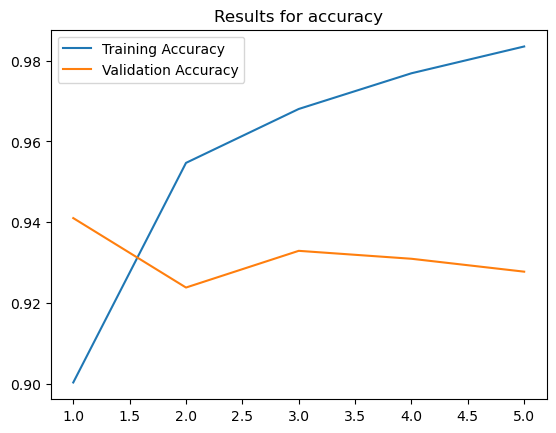

In [100]:
#Ploting the accuracy metric across the epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [101]:
score = model.evaluate(X_test_seq_padded,y_test_encode, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

Test loss: 0.17122280597686768
Test accuracy: 0.9410029649734497


In [102]:
class_names = np.unique(y_test)
class_names

array([0., 1.])

In [103]:
len(X_test_seq_padded)

4068

In [104]:
y_pred = model.predict(X_test_seq_padded)

128/128 [==============================] - 3s 21ms/step


In [105]:
y_pred_new = [0 if i[0] > i[1] else 1 for i in y_pred]

In [106]:
y_test = [1 if i == 'Consumer' else 0 for i in y_test]

In [107]:
len(y_test)

4068

In [108]:
len(y_pred_new)

4068

In [109]:
print(accuracy_score(y_test,y_pred_new))
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(classification_report(y_test,y_pred_new))

0.4909046214355949
				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       1.00      0.49      0.66      4068
           1       0.00      0.00      0.00         0

    accuracy                           0.49      4068
   macro avg       0.50      0.25      0.33      4068
weighted avg       1.00      0.49      0.66      4068



/opt/homebrew/Caskroom/miniforge/base/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/python_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Prediction

In [54]:
print(len(data_pred))
data_pred = data_pred.dropna(subset='tweet')
print(len(data_pred))

345372
345372


In [55]:
#Vectorization
x_vectors = fitted_vectorizer.transform(data_pred['tweet'])

In [56]:
x_vectors.shape

(345372, 213650)

In [60]:
pred = model_svm.predict(x_vectors)

In [61]:
data_pred['prediction'] = pred

In [62]:
len(data_pred[data_pred['prediction'] == 1])

191601

In [63]:
data_pred_consumer = data_pred[data_pred['prediction'] == 1]
data_train_consumer = data_train[data_train['Category'] == 1]

In [64]:
data = pd.concat([data_pred_consumer,data_train_consumer])

In [65]:
print(len(data))
data = data.drop_duplicates(subset='tweet')
print(len(data))

199838
197824


In [66]:
data.to_csv('Consumer_data.csv', index = False)